# EDA

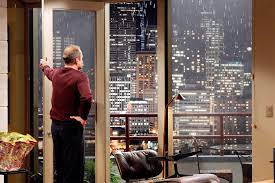

In [430]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Getting the Data from progreSQL, using DBeaver

In [431]:
import os
from dotenv import load_dotenv
import psycopg2

load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

### 1.1 Opening the connection, using the information from the .env file

In [432]:
# Open connection
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

### 1.2 Run query, save it to a pandas df and save the file locally (into the Data folder)

In [433]:
# import the data into a pandas dataframe
query_string = "SET SCHEMA 'eda'; SELECT * FROM king_county_house_sales AS sales FULL JOIN king_county_house_details AS details ON sales.house_id = details.id"
df_psycopg = pd.read_sql(query_string, conn)

#Saving the data locally
df_psycopg.to_csv("/Users/luca/neuefische/EDA-Project/data/king_county_housing_data.csv", index=False)


### 1.3 Close connection to DB

In [434]:
#close the connection
conn.close()

### 1.4 Dataframe check for completeness

In [435]:
df_psycopg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   id             21597 non-null  int64  
 5   bedrooms       21597 non-null  float64
 6   bathrooms      21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   sqft_lot       21597 non-null  float64
 9   floors         21597 non-null  float64
 10  waterfront     19206 non-null  float64
 11  view           21534 non-null  float64
 12  condition      21597 non-null  int64  
 13  grade          21597 non-null  int64  
 14  sqft_above     21597 non-null  float64
 15  sqft_basement  21145 non-null  float64
 16  yr_built       21597 non-null  int64  
 17  yr_renovated   17749 non-null  float64
 18  zipcod

## 2. First Data exploration and cleaning, using local data copy

In [436]:
# Assigning new name to Dataframe 
df = pd.read_csv("/Users/luca/neuefische/EDA-Project/data/king_county_housing_data.csv")

df.shape

(21597, 23)

In [437]:
#check column names
df.columns

Index(['date', 'price', 'house_id', 'id', 'id.1', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

<Axes: >

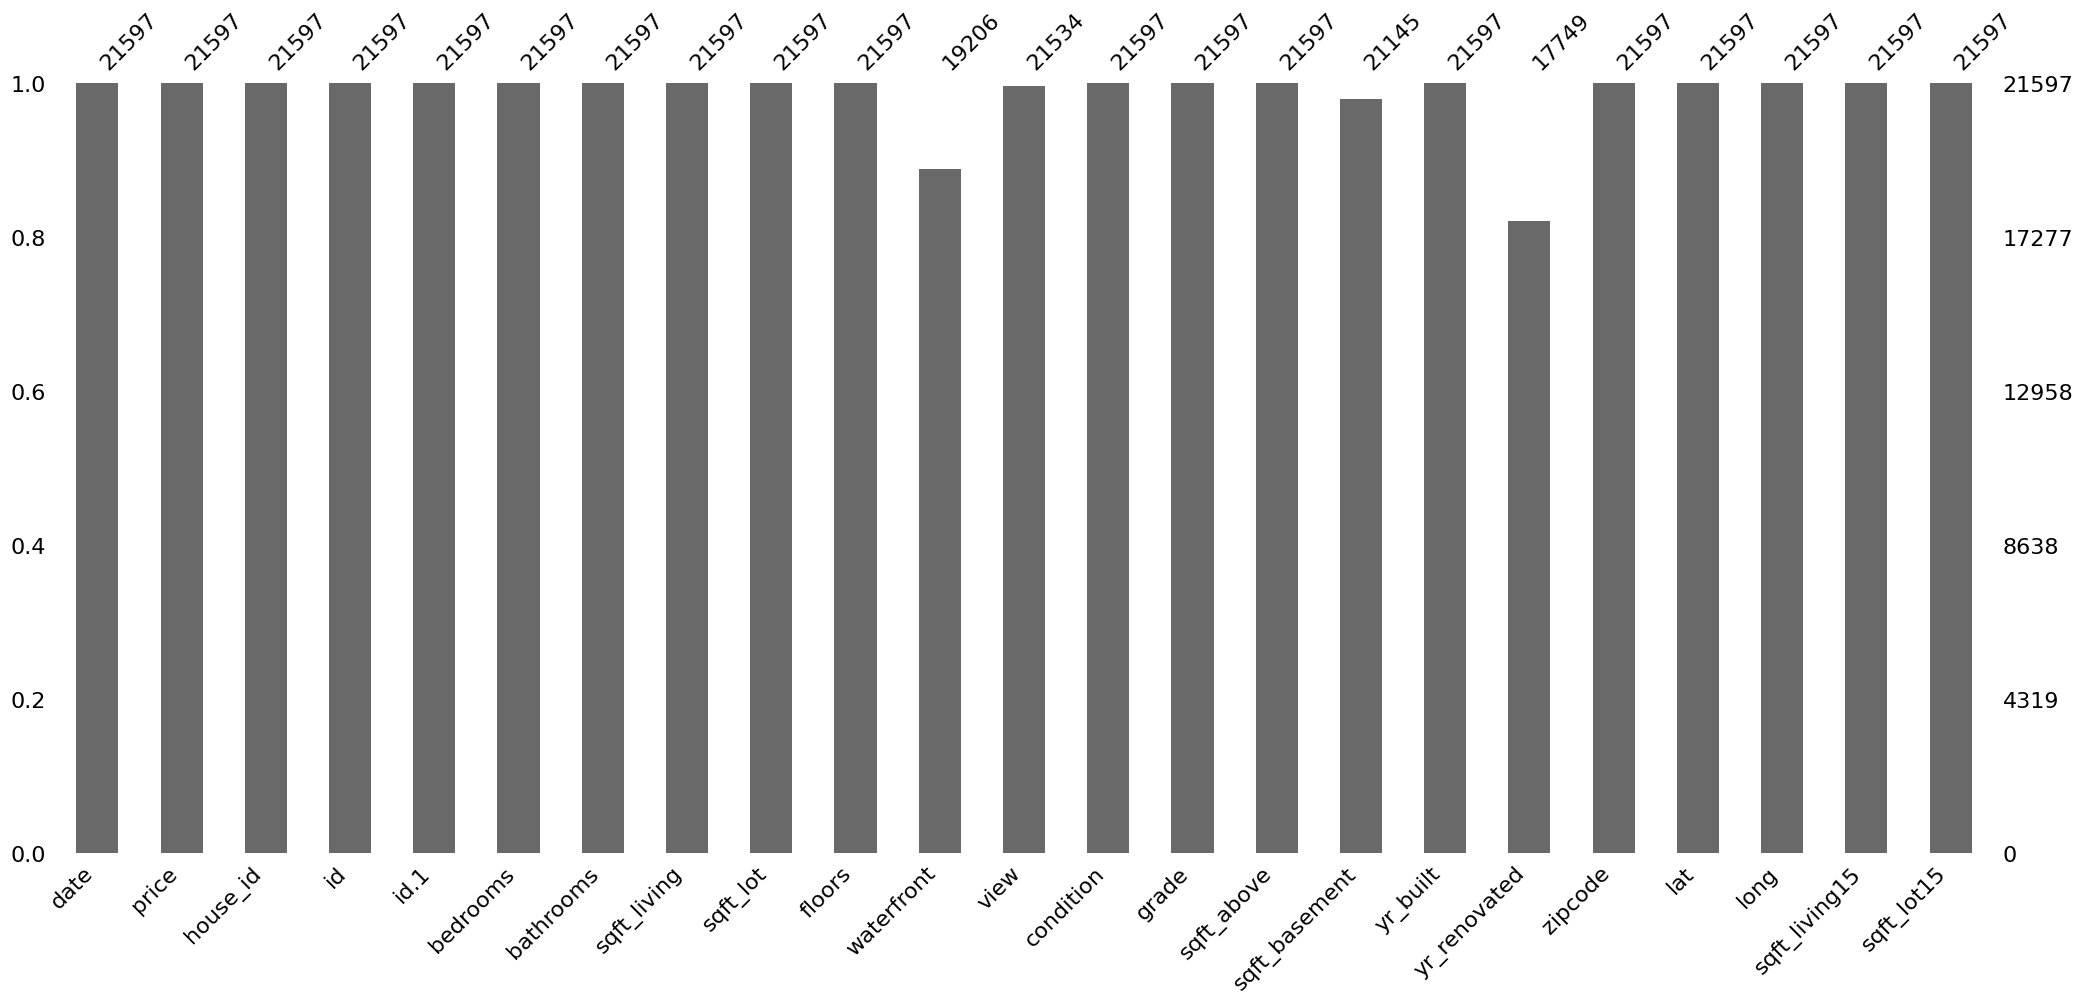

In [438]:
# inspecting for missing data
msno.bar(df)

<Axes: >

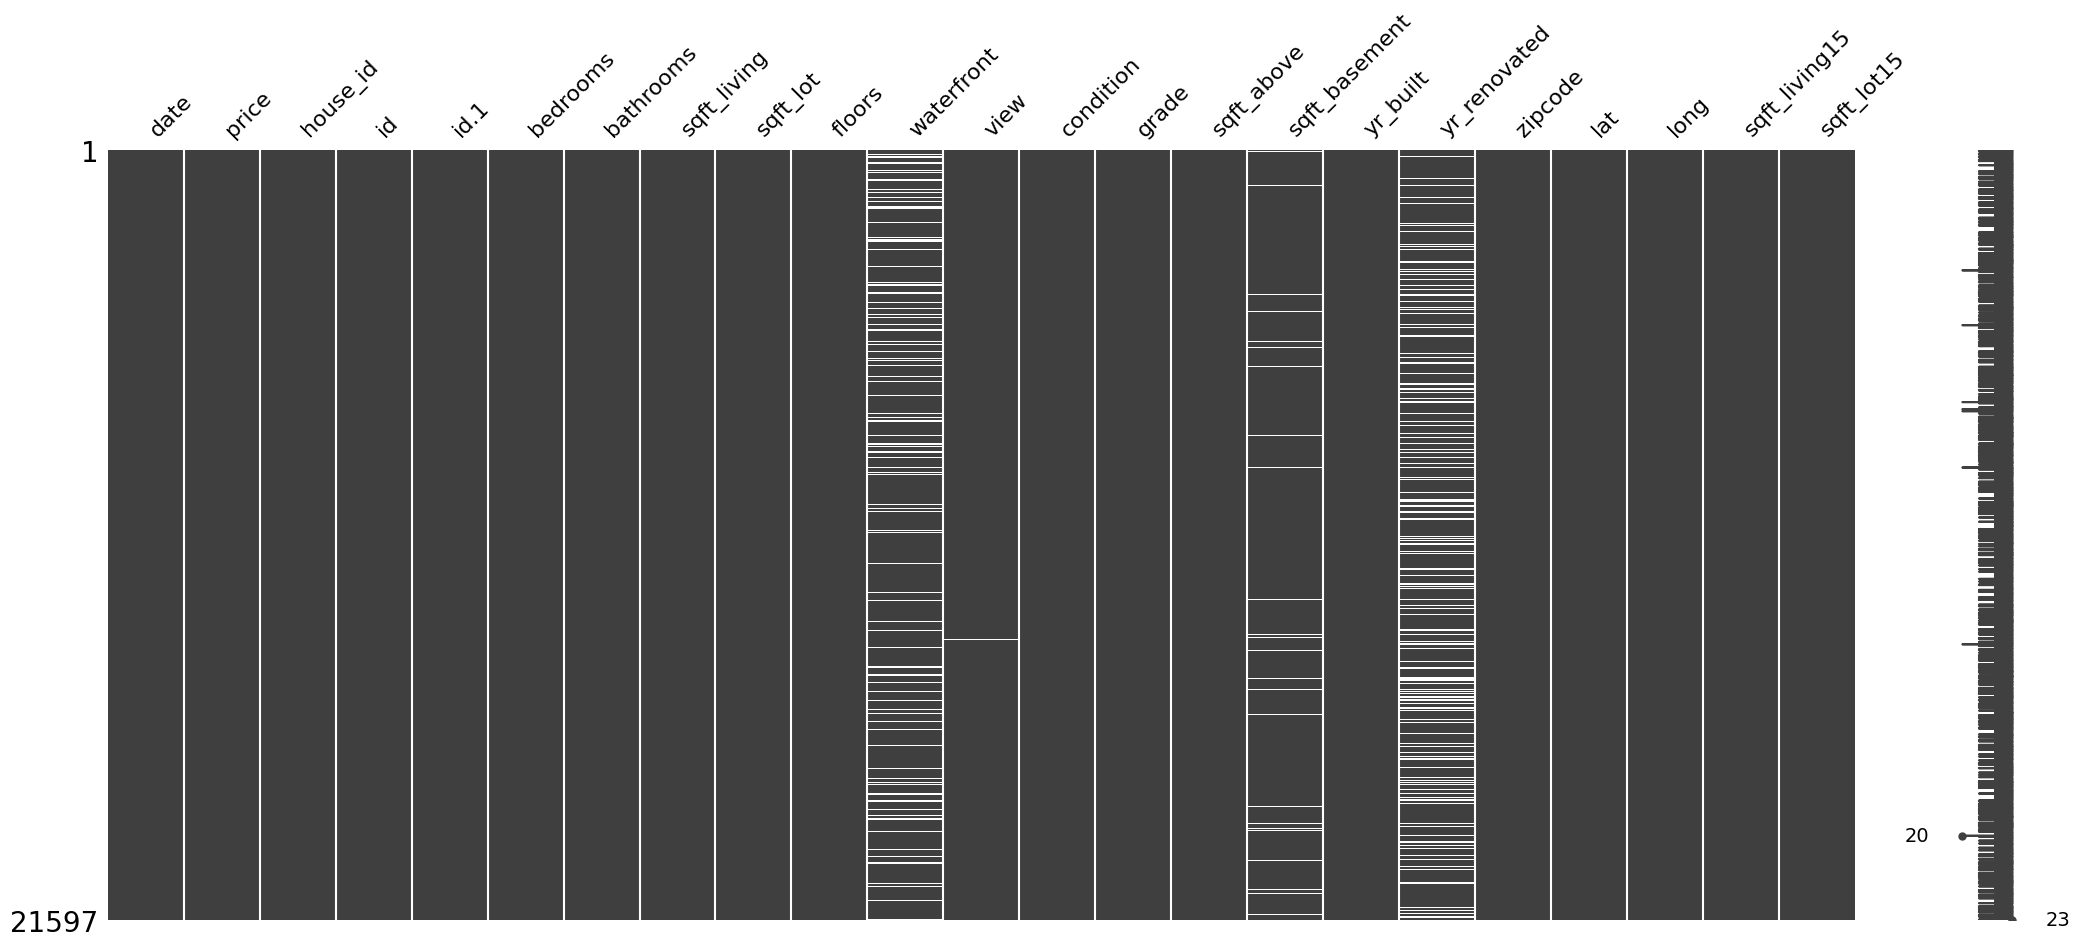

In [439]:
msno.matrix(df)

'The image seems to be mostly white, which suggests that there are either no strong correlations between the missing values of these columns or \nthat the data is not missing in a correlated way. The lack of visible squares or color also suggests that missing data may not be a significant issue\nfor these particular columns or that the DataFrame is quite complete with few to no missing values.'

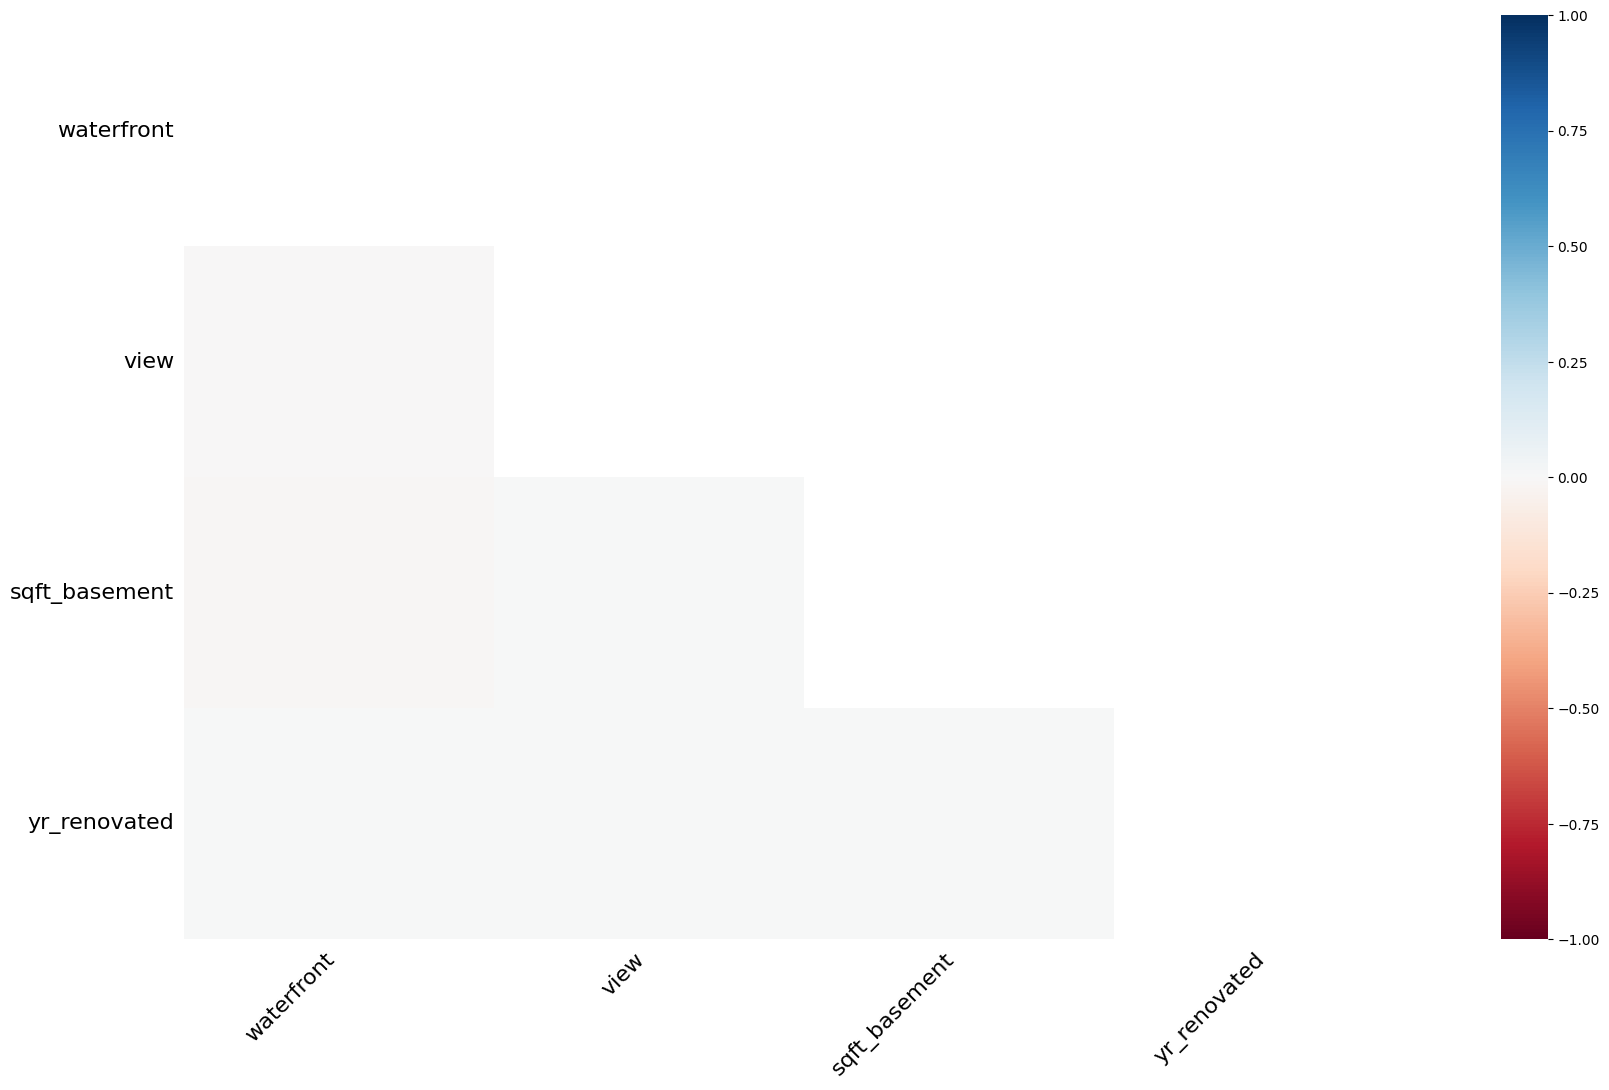

In [440]:
# heatmap shows, that there correlation is always around 0
msno.heatmap(df)


'''The image seems to be mostly white, which suggests that there are either no strong correlations between the missing values of these columns or 
that the data is not missing in a correlated way. The lack of visible squares or color also suggests that missing data may not be a significant issue
for these particular columns or that the DataFrame is quite complete with few to no missing values.'''

'We can see several groups of columns clustered at different levels of the hierarchy.\nThe columns grouped at the lowest point (closest to 0 on the y-axis) are most similar to \neach other in terms of their missing data pattern, which means they tend to either have \nmissing data simultaneously or be non-missing together.\nFor example, the group containing sqft_basement, view, and waterfront is likely indicating \nthat these columns have missing data that is closely related—when one is missing, the others \nare likely to be missing as well.\nOn the other hand, columns like price, date, house_id, and so on are clustered much higher, \nwhich suggests their missing data patterns are less similar to the other columns.'

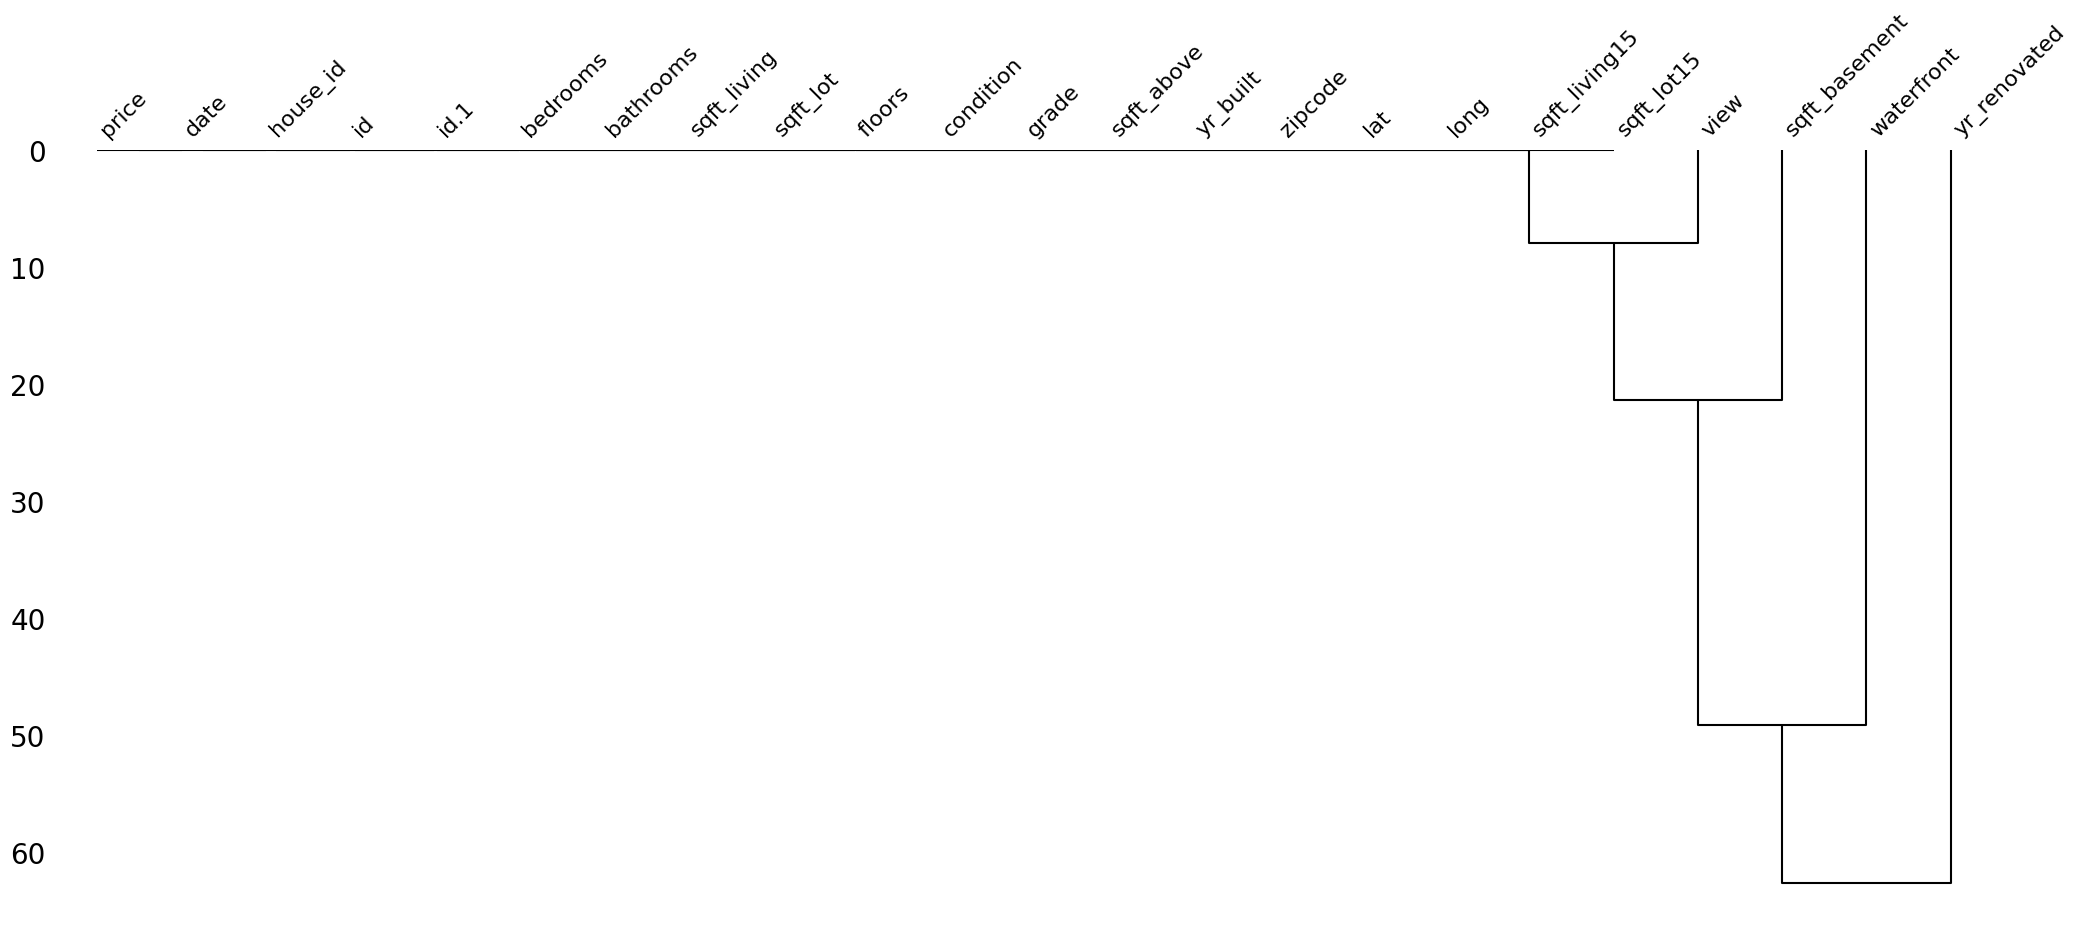

In [441]:
msno.dendrogram(df)

'''We can see several groups of columns clustered at different levels of the hierarchy.
The columns grouped at the lowest point (closest to 0 on the y-axis) are most similar to 
each other in terms of their missing data pattern, which means they tend to either have 
missing data simultaneously or be non-missing together.
For example, the group containing sqft_basement, view, and waterfront is likely indicating 
that these columns have missing data that is closely related—when one is missing, the others 
are likely to be missing as well.
On the other hand, columns like price, date, house_id, and so on are clustered much higher, 
which suggests their missing data patterns are less similar to the other columns.'''

In [442]:
#Inspecting the data types for each column
df.dtypes

date              object
price            float64
house_id           int64
id                 int64
id.1               int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

In [443]:
#Check if id.1 and id have the same values. I assume a duplication due to the full join when pulling the data from the postgreSQL DB.
df[["id.1", "id"]].sort_values(by=["id.1", "id"], ascending=False)

id.1     id
15937  9900000190  15938
20963  9895000040  20964
7614   9842300540   7615
3257   9842300485   3258
16723  9842300095  16724
...           ...    ...
8800      2800031   8801
8404      1200021   8405
6729      1200019   6730
2495      1000102   2496
2494      1000102   2495

[21597 rows x 2 columns]

In [444]:
#eliminating id column, since it contains the same information as house_id
df = df.drop(columns=["id"])

In [445]:
#eliminating id.1 column, since it contains the same information as house_id
df = df.drop(columns=["id.1"])

In [446]:
# Check if columns were properly removed
df.shape

(21597, 21)

In [447]:
df.dtypes

date              object
price            float64
house_id           int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

In [448]:
# Convert the "date" column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

#Check if date has been properly manipulated
df["date"]


0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [449]:
#Inspecting the format for the values in price
df["price"]

0       221900.000
1       538000.000
2       180000.000
3       604000.000
4       510000.000
           ...    
21592   360000.000
21593   400000.000
21594   402101.000
21595   400000.000
21596   325000.000
Name: price, Length: 21597, dtype: float64

In [450]:
# Custom function to format float with commas as thousands separators
def format_price(price):
    return '{:,.2f}'.format(price)

# Apply the custom formatting function to the "price" column when displaying the DataFrame
df['price_formatted'] = df['price'].apply(format_price)


In [451]:
#Converting zipcode to category, since this is not a value we would be calculating with
df["zipcode"] = df["zipcode"].astype("category")
df["zipcode"]


0        98178
1        98125
2        98028
3        98136
4        98074
         ...  
21592    98103
21593    98146
21594    98144
21595    98027
21596    98144
Name: zipcode, Length: 21597, dtype: category
Categories (70, int64): [98001, 98002, 98003, 98004, ..., 98178, 98188, 98198, 98199]

In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             21597 non-null  datetime64[ns]
 1   price            21597 non-null  float64       
 2   house_id         21597 non-null  int64         
 3   bedrooms         21597 non-null  float64       
 4   bathrooms        21597 non-null  float64       
 5   sqft_living      21597 non-null  float64       
 6   sqft_lot         21597 non-null  float64       
 7   floors           21597 non-null  float64       
 8   waterfront       19206 non-null  float64       
 9   view             21534 non-null  float64       
 10  condition        21597 non-null  int64         
 11  grade            21597 non-null  int64         
 12  sqft_above       21597 non-null  float64       
 13  sqft_basement    21145 non-null  float64       
 14  yr_built         21597 non-null  int64

In [453]:
import plotly.express as px

# Using the scatter_mapbox function to plot using OpenStreetMap
fig = px.scatter_mapbox(df,
                        lat="lat",
                        lon="long",
                        hover_name="house_id", 
                        color_discrete_sequence=["fuchsia"],
                        zoom=10,  # Zoom level
                        height=300,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()





In [454]:
import pandas as pd
import plotly.express as px


# condition to categorize prices - adjust thresholds as necessary
conditions = [
    (df['price'] <= 300000),
    (df['price'] > 300000) & (df['price'] <= 600000),
    (df['price'] > 600000) & (df['price'] <= 900000),
    (df['price'] > 900000)
]

# Define categories
categories = ['green', 'yellow', 'orange', 'red']

# Create a new column with these categories based on the conditions
df['price_category'] = np.select(conditions, categories)


# Update the scatter_mapbox function call to include hover_data
fig = px.scatter_mapbox(df,
                        lat="lat",
                        lon="long",
                        hover_name="house_id",
                        hover_data={"price": ":,",  # Format the price with commas
                                    "price_category": False},  # Exclude price_category from the hover data
                        color="price_category",  # Use the 'price_category' column for coloring
                        color_discrete_map={"green": "green", "yellow": "yellow", "orange": "orange", "red": "red"},  # Map categories to colors
                        zoom=10,  # Zoom level
                        height=600,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             21597 non-null  datetime64[ns]
 1   price            21597 non-null  float64       
 2   house_id         21597 non-null  int64         
 3   bedrooms         21597 non-null  float64       
 4   bathrooms        21597 non-null  float64       
 5   sqft_living      21597 non-null  float64       
 6   sqft_lot         21597 non-null  float64       
 7   floors           21597 non-null  float64       
 8   waterfront       19206 non-null  float64       
 9   view             21534 non-null  float64       
 10  condition        21597 non-null  int64         
 11  grade            21597 non-null  int64         
 12  sqft_above       21597 non-null  float64       
 13  sqft_basement    21145 non-null  float64       
 14  yr_built         21597 non-null  int64

In [456]:
df["yr_renovated"].unique()

array([    0., 19910.,    nan, 20020., 20100., 19920., 20130., 19940.,
       19780., 20050., 20030., 19840., 19540., 20140., 20110., 19830.,
       19450., 19900., 19880., 19770., 19810., 19950., 20000., 19990.,
       19980., 19700., 19890., 20040., 19860., 20070., 19870., 20060.,
       19850., 20010., 19800., 19710., 19790., 19970., 19500., 19690.,
       19480., 20090., 20150., 19740., 20080., 19680., 20120., 19630.,
       19510., 19620., 19530., 19930., 19960., 19550., 19820., 19560.,
       19400., 19760., 19460., 19750., 19640., 19730., 19570., 19590.,
       19600., 19670., 19650., 19340., 19720., 19440., 19580.])

In [472]:
# Display unique values
unique_values = df["yr_renovated"].unique()

# Count of 0 values
count_zeros = (df["yr_renovated"] == 0).sum()

# Count of NaN values
count_nans = df["yr_renovated"].isna().sum()

print(f" The column yr_renovated contains {unique_values} unique values, {count_zeros} a zero and {count_nans} NaNs.")



# 1. NaN typically indicates missing data. This could mean that the renovation year is unknown: it was either not recorded, lost, or 
# the question was not applicable at the time of data collection.
# 2. 0 could explicitly indicate that the house has never been renovated, given as a definitive answer rather than an omission.

# Assuming all houses represented by either 0 or NaN have not been renovated is could be an approach, especially since I am lacking
# further information to differentiate these cases.

 The column yr_renovated contains [    0. 19910.    nan 20020. 20100. 19920. 20130. 19940. 19780. 20050.
 20030. 19840. 19540. 20140. 20110. 19830. 19450. 19900. 19880. 19770.
 19810. 19950. 20000. 19990. 19980. 19700. 19890. 20040. 19860. 20070.
 19870. 20060. 19850. 20010. 19800. 19710. 19790. 19970. 19500. 19690.
 19480. 20090. 20150. 19740. 20080. 19680. 20120. 19630. 19510. 19620.
 19530. 19930. 19960. 19550. 19820. 19560. 19400. 19760. 19460. 19750.
 19640. 19730. 19570. 19590. 19600. 19670. 19650. 19340. 19720. 19440.
 19580.] unique values, 17005 a zero and 3848 NaNs.


' 1. NaN typically indicates missing data. This could mean that the renovation year is unknown: it was either not recorded, lost, or \nthe question was not applicable at the time of data collection.\n2. 0 could explicitly indicate that the house has never been renovated, given as a definitive answer rather than an omission.\n\nAssuming all houses represented by either 0 or NaN have not been renovated is could be an approach, especially since I am lacking\nfurther information to differentiate these cases.'

In [473]:
# Applying the transformation to remove the "extra 0" at the end of every float and creating a new column
df['yr_renovated_cleaned'] = df['yr_renovated'].apply(lambda x: x / 10 if (x % 10 == 0 and x != 0) else x)
df['yr_renovated_cleaned'] = df['yr_renovated_cleaned'].apply(lambda x: int(x) if not pd.isnull(x) else x)

# Display the first few rows to verify the new column creation and transformation
df.head()  

date      price    house_id  bedrooms  bathrooms  sqft_living  \
0 2014-10-13 221900.000  7129300520     3.000      1.000     1180.000   
1 2014-12-09 538000.000  6414100192     3.000      2.250     2570.000   
2 2015-02-25 180000.000  5631500400     2.000      1.000      770.000   
3 2014-12-09 604000.000  2487200875     4.000      3.000     1960.000   
4 2015-02-18 510000.000  1954400510     3.000      2.000     1680.000   

   sqft_lot  floors  waterfront  view  ...  yr_built  yr_renovated  zipcode  \
0  5650.000   1.000         NaN 0.000  ...      1955         0.000    98178   
1  7242.000   2.000       0.000 0.000  ...      1951     19910.000    98125   
2 10000.000   1.000       0.000 0.000  ...      1933           NaN    98028   
3  5000.000   1.000       0.000 0.000  ...      1965         0.000    98136   
4  8080.000   1.000       0.000 0.000  ...      1987         0.000    98074   

     lat     long  sqft_living15 sqft_lot15  price_formatted  price_category  \
0 47.511 -122.257       1340.000   5650.000       221,900.00           green   
1 47.721 -122.319       1690.000   7639.000       538,000.00          yellow   
2 47.738 -122.233       2720.000   8062.000       180,000.00           green   
3 47.521 -122.393       1360.000   5000.000       604,000.00          orange   
4 47.617 -122.045       1800.000   7503.000       510,000.00          yellow   

   yr_renovated_cleaned  
0                 0.000  
1              1991.000  
2                   NaN  
3                 0.000  
4                 0.000  

[5 rows x 24 columns]

In [474]:
# Display unique values
unique_values2 = df["yr_renovated_cleaned"].unique()

# Count of 0 values
count_zeros2 = (df["yr_renovated_cleaned"] == 0).sum()

# Count of NaN values
count_nans2 = df["yr_renovated_cleaned"].isna().sum()

print(f" The column yr_renovated contains {unique_values2} unique values, {count_zeros2} a zero and {count_nans2} NaNs.")

 The column yr_renovated contains [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.] unique values, 17005 a zero and 3848 NaNs.


In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             21597 non-null  datetime64[ns]
 1   price            21597 non-null  float64       
 2   house_id         21597 non-null  int64         
 3   bedrooms         21597 non-null  float64       
 4   bathrooms        21597 non-null  float64       
 5   sqft_living      21597 non-null  float64       
 6   sqft_lot         21597 non-null  float64       
 7   floors           21597 non-null  float64       
 8   waterfront       19206 non-null  float64       
 9   view             21534 non-null  float64       
 10  condition        21597 non-null  int64         
 11  grade            21597 non-null  int64         
 12  sqft_above       21597 non-null  float64       
 13  sqft_basement    21145 non-null  float64       
 14  yr_built         21597 non-null  int64

In [470]:
# Display unique values
unique_values_wf = df["waterfront"].unique()

# Count of 0 values
count_zeros_wf = (df["yr_renovated"] == 0).sum()

# Count of NaN values
count_nans_wf = df["yr_renovated"].isna().sum()


print(f" The column waterfront contains {unique_values_wf} unique values, {count_zeros_wf} a zero and {count_nans_wf} NaNs.")

 The column waterfront contains [nan  0.  1.] unique values, 17005 a zero and 3848 NaNs.


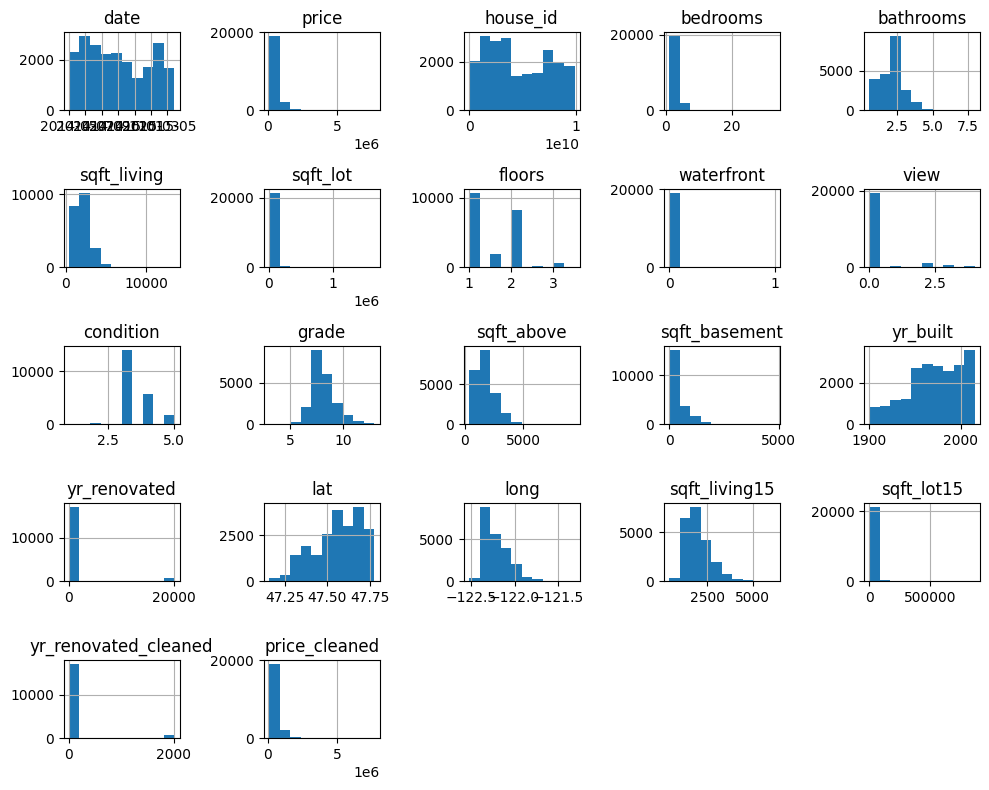

In [488]:
#Inspecting the distirbution of all numerical variables

df.hist(figsize=(10, 8))
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


### The histogram visualizations present an insightful summary of the dataset's variables:

1. Date: Certain dates or periods exhibit higher frequencies of data points, suggesting specific dates with increased sales activity.

2. Price: The price distribution is notably right-skewed, with most properties priced lower and a few high-priced outliers.

3. House ID: Displaying a uniform spread consistent with unique identifiers for properties.

4. Bedrooms and Bathrooms: Both feature right-skewed distributions, indicating that most houses have a lower count with some exceptional cases.
Square Footage (Living and Lot): Right-skewed distributions are observed, implying smaller living spaces and lot sizes are more prevalent, with some larger-size outliers.

5. Floors: Shows a pattern with predominant groupings around 1 to 3 floors, with single and two-story homes being most common.

6. Waterfront: Predominantly indicating the absence of waterfront locations for most properties.

7. View: Concentrated at a zero rating, suggesting few properties have premium views.

8. Condition: Skews towards the average with fewer homes in poor or excellent condition.

9. Grade: Reflects a concentration around the mid-grade with fewer properties at the high and low ends of the scale.
Square Footage (Above and Basement): Both distributions are right-skewed; many properties lack a basement, as evidenced by the spike at zero.

9. Year Built: Illustrates diversity in construction years, with a modest trend towards more recent construction.

10. Year Renovated: Features a significant spike at zero, likely indicating non-renovated properties, with a spread of renovations across various years.

11. Latitude and Longitude: Distributions are narrowly focused, suggesting a specific geographic clustering of the properties.

12. Square Footage (Living15 and Lot15): Both likely represent measurements in 2015 and are right-skewed, akin to their respective overall square footage counterparts.

13. Year Renovated (Cleaned): Mirrors the Year Renovated graph but corrects the data anomalies, displaying a pronounced peak at zero for properties without renovations.

In [479]:
price_unique = df["price"].unique()
price_unique

array([221900., 538000., 180000., ..., 541800., 610685., 402101.])

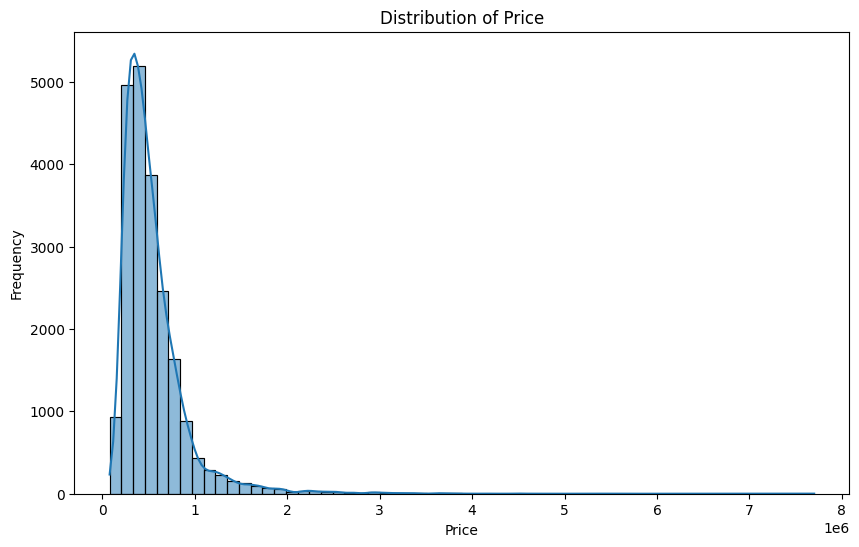

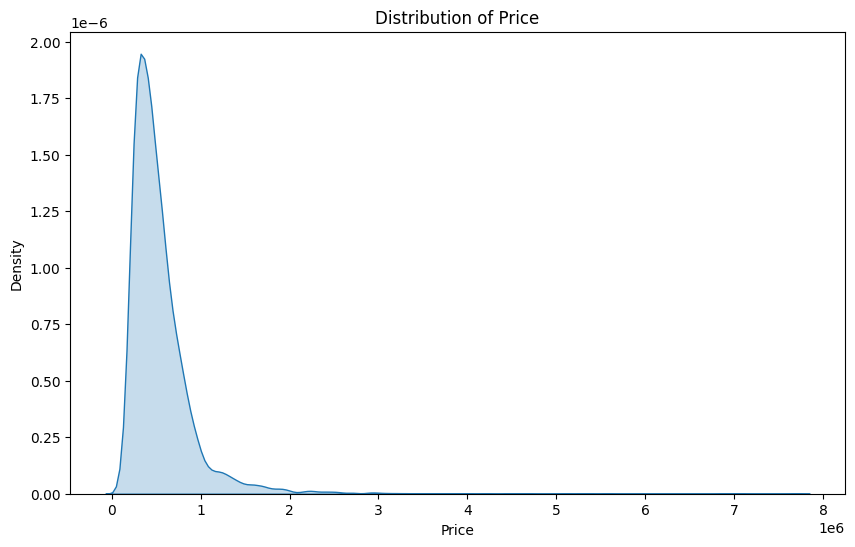

In [482]:
# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=60, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plotting kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['price'], shade=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()


In [483]:
# Create a new column "price_cleaned" and convert the values from "price" column to integer
df['price_cleaned'] = df['price'].astype(int)


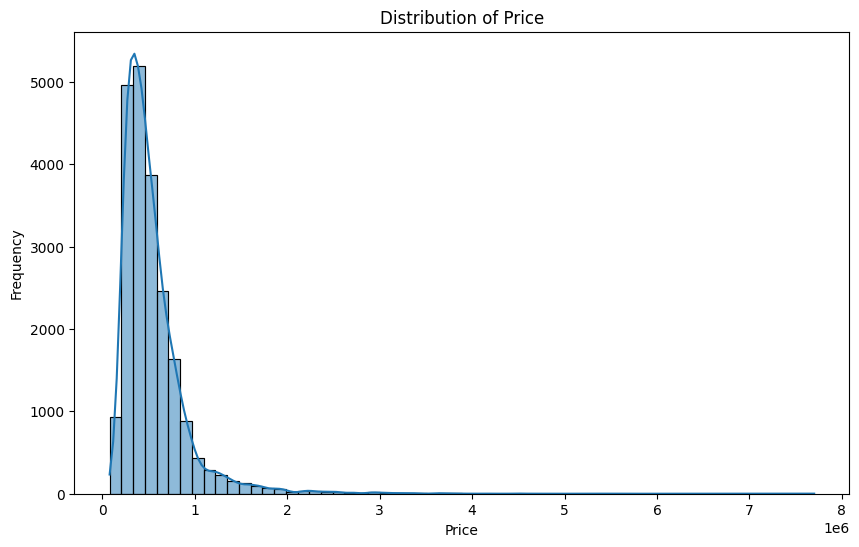

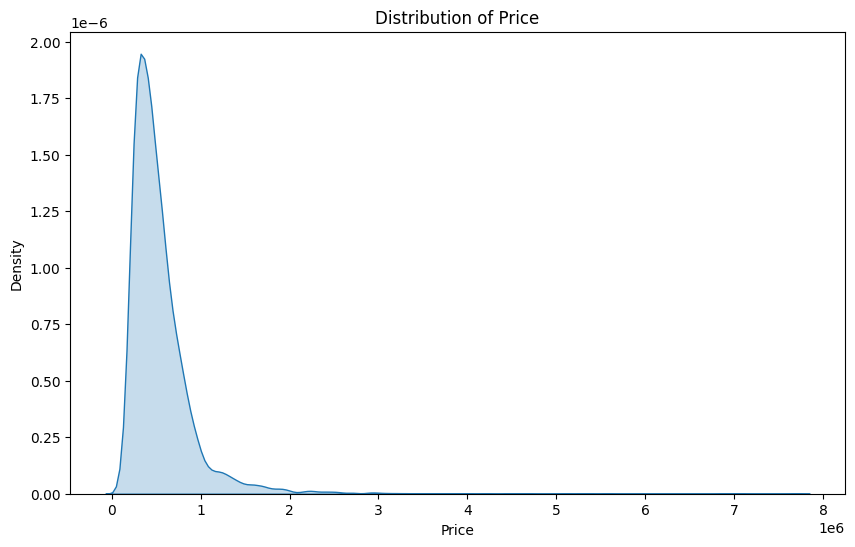

In [487]:
# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=60, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plotting kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['price'], shade=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

## 4. Hypothesis Testing

H1: Historic houses are more likely to have larger lots, which could accommodate Jacob's desire for a tennis court and/or pool.

Definition of Historiy: U.S. National Register.

"Age and Integrity: Is the property old enough to be considered historic (generally at least 50 years old) and does it still look much the way it did in the past?"
https://www.nps.gov/subjects/nationalregister/how-to-list-a-property.htm

large lot = fits a tennis court (approx. 2800 sqft) and a pool (approx. 5000sqft), plus extra space, in total 20000+ sqft is to be considered large

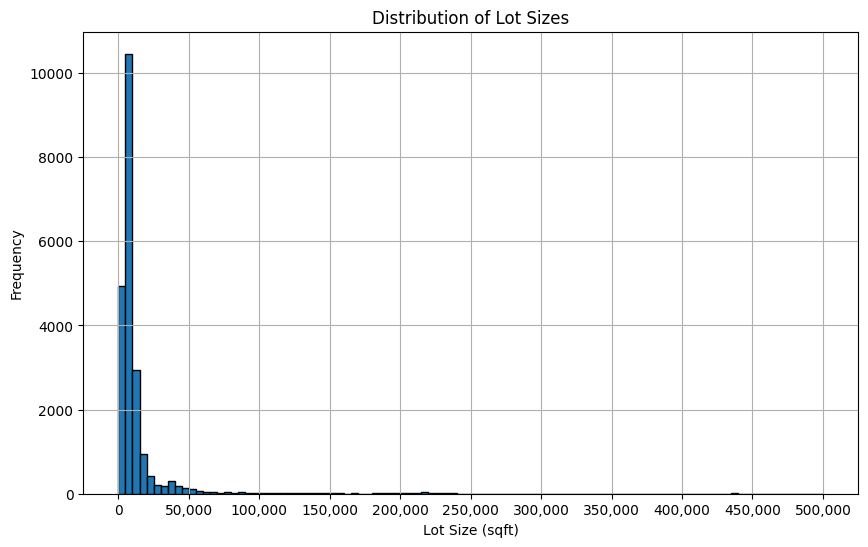

In [520]:

#avg_lot_sizes = df['sqft_lot'].mean()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['sqft_lot'], bins=100, edgecolor='black', range=(0, 500000))
plt.title('Distribution of Lot Sizes')
plt.xlabel('Lot Size (sqft)')
plt.ylabel('Frequency')
plt.grid(True)

# Set the x-axis ticks to be at intervals of 50000
plt.xticks(np.arange(0, 500001, 50000))

# Format with commas and without scientific notation
plt.gca().ticklabel_format(style='plain', axis='x')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


In [522]:
df["yr_built"].max()#head(10).sort_values(ascending=False)

2015

In [525]:
# Filter the DataFrame to show all buildings built before 1965
df_buildings_before_1965 = df[df['yr_built'] < 1965]

# Display the filtered DataFrame
df_buildings_before_1965


date      price    house_id  bedrooms  bathrooms  sqft_living  \
0     2014-10-13 221900.000  7129300520     3.000      1.000     1180.000   
1     2014-12-09 538000.000  6414100192     3.000      2.250     2570.000   
2     2015-02-25 180000.000  5631500400     2.000      1.000      770.000   
7     2015-01-15 291850.000  2008000270     3.000      1.500     1060.000   
8     2015-04-15 229500.000  2414600126     3.000      1.000     1780.000   
...          ...        ...         ...       ...        ...          ...   
21287 2015-04-29 465000.000   522059130     3.000      1.000     1150.000   
21316 2015-05-11 245000.000  9266700190     1.000      1.000      390.000   
21327 2014-09-25 332220.000  2924079034     3.000      1.500     2580.000   
21454 2015-01-09 249000.000   121039156     3.000      1.000     1030.000   
21567 2014-06-10 399950.000  2025049203     2.000      1.000      710.000   

       sqft_lot  floors  waterfront  view  ...  yr_renovated  zipcode    lat  \
0      5650.000   1.000         NaN 0.000  ...         0.000    98178 47.511   
1      7242.000   2.000       0.000 0.000  ...     19910.000    98125 47.721   
2     10000.000   1.000       0.000 0.000  ...           NaN    98028 47.738   
7      9711.000   1.000       0.000   NaN  ...         0.000    98198 47.410   
8      7470.000   1.000       0.000 0.000  ...         0.000    98146 47.512   
...         ...     ...         ...   ...  ...           ...      ...    ...   
21287 18200.000   1.000       0.000 0.000  ...         0.000    98058 47.426   
21316  2000.000   1.000       0.000 0.000  ...         0.000    98103 47.694   
21327 47480.000   1.000       0.000 0.000  ...         0.000    98024 47.533   
21454 24750.000   1.000       0.000 2.000  ...         0.000    98023 47.334   
21567  1157.000   2.000         NaN 0.000  ...         0.000    98102 47.641   

          long  sqft_living15  sqft_lot15 price_formatted  price_category  \
0     -122.257       1340.000    5650.000      221,900.00           green   
1     -122.319       1690.000    7639.000      538,000.00          yellow   
2     -122.233       2720.000    8062.000      180,000.00           green   
7     -122.315       1650.000    9711.000      291,850.00           green   
8     -122.337       1780.000    8113.000      229,500.00           green   
...        ...            ...         ...             ...             ...   
21287 -122.187       1714.000   18200.000      465,000.00          yellow   
21316 -122.347       1340.000    5100.000      245,000.00           green   
21327 -121.933       1760.000   48181.000      332,220.00          yellow   
21454 -122.362       2810.000   28800.000      249,000.00           green   
21567 -122.329       1370.000    1173.000      399,950.00          yellow   

       yr_renovated_cleaned  price_cleaned  
0                     0.000         221900  
1                  1991.000         538000  
2                       NaN         180000  
7                     0.000         291850  
8                     0.000         229500  
...                     ...            ...  
21287                 0.000         465000  
21316                 0.000         245000  
21327                 0.000         332220  
21454                 0.000         249000  
21567                 0.000         399950  

[8596 rows x 25 columns]

In [526]:
from scipy import stats

# Define 'historic' as houses built before 1965
historic_threshold_year = 1965

# Create two subsets of the data
historic_houses = df[df['yr_built'] < historic_threshold_year]
non_historic_houses = df[df['yr_built'] >= historic_threshold_year]

# Task 1: Perform a t-test to see if there's a significant difference in lot sizes
# between historic and non-historic houses.
t_statistic, p_value = stats.ttest_ind(historic_houses['sqft_lot'],
                                       non_historic_houses['sqft_lot'],
                                       equal_var=False)  # Assumes unequal population variances
print(f"T-statistic: {t_statistic}, P-value: {p_value}")

# Task 2: Conduct correlation analysis to evaluate the relationship
# between the year the house was built (yr_built) and lot size (sqft_lot).
correlation_coefficient, p_value_corr = stats.pearsonr(df['yr_built'], df['sqft_lot'])
print(f"Correlation Coefficient: {correlation_coefficient}, P-value: {p_value_corr}")

# Note: Interpret the p-value from the t-test to determine if the differences
# in lot sizes are statistically significant (typically, p < 0.05 is considered significant).
# The correlation coefficient will tell you the strength and direction of the relationship
# between 'yr_built' and 'sqft_lot'.

T-statistic: -10.98287197639815, P-value: 5.499833098728766e-28
Correlation Coefficient: 0.05294630704712118, P-value: 6.918775052167779e-15


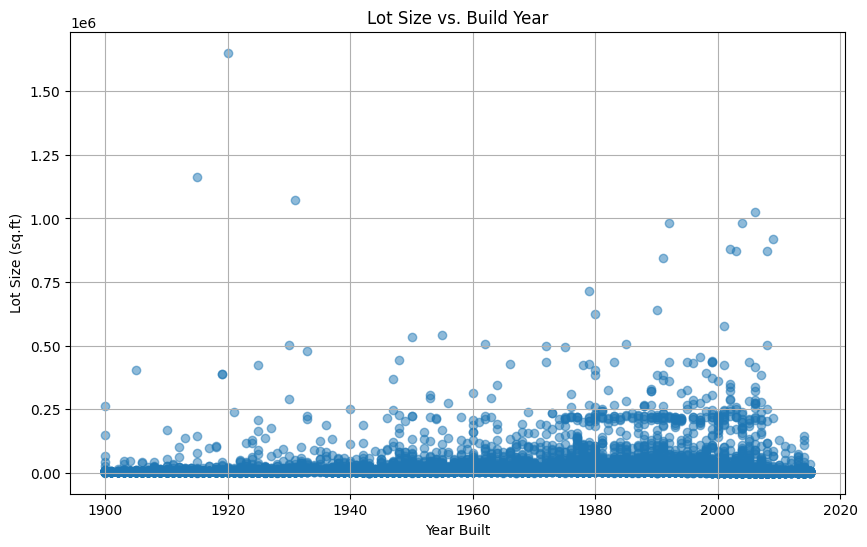

In [527]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['yr_built'], df['sqft_lot'], alpha=0.5)
plt.title('Lot Size vs. Build Year')
plt.xlabel('Year Built')
plt.ylabel('Lot Size (sq.ft)')
plt.grid(True)
plt.show()


In [532]:
# Defined the threshold for what constitutes a "large lot"
large_lot_threshold = 20000

# Filter for historic houses built before 1965 with large lots
historic_large_lot_houses = df[(df['yr_built'] < 1965) & (df['sqft_lot'] >= large_lot_threshold)]

# Create the Plotly figure
fig = px.scatter_mapbox(historic_large_lot_houses,
                        lat="lat",
                        lon="long",
                        hover_name="house_id",
                        hover_data={"yr_built": True, "sqft_lot": True},
                        color_discrete_sequence=["fuchsia"], 
                        zoom=10,
                        height=900)

# Set the mapbox style to "open-street-map"
fig.update_layout(mapbox_style="open-street-map")

# Update the layout to adjust titles and more
fig.update_layout(
    title='Geographic Distribution of Historic Houses with Large Lots in Seattle',
    geo_scope='usa',  # Limit map scope to USA
)

# Show the figure
fig.show()



## Evaluation of Hypothesis 1:
### Statistical analysis disproves the assumption that historic houses generally have larger lots for amenities like tennis courts or pools. The T-test, revealing a significant difference with historic houses having smaller lots on average, and a weak positive correlation between construction year and lot size, indicate that newer houses tend to have slightly larger lots. Thus, the data contradicts the idea that historic homes are better suited for Jacob's desire for large lot amenities, suggesting instead that newer homes may offer more space for such facilities.

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  21597 non-null  datetime64[ns]
 1   price                 21597 non-null  float64       
 2   house_id              21597 non-null  int64         
 3   bedrooms              21597 non-null  float64       
 4   bathrooms             21597 non-null  float64       
 5   sqft_living           21597 non-null  float64       
 6   sqft_lot              21597 non-null  float64       
 7   floors                21597 non-null  float64       
 8   waterfront            19206 non-null  float64       
 9   view                  21534 non-null  float64       
 10  condition             21597 non-null  int64         
 11  grade                 21597 non-null  int64         
 12  sqft_above            21597 non-null  float64       
 13  sqft_basement   

In [534]:
df["zipcode"].head()

0    98178
1    98125
2    98028
3    98136
4    98074
Name: zipcode, dtype: category
Categories (70, int64): [98001, 98002, 98003, 98004, ..., 98178, 98188, 98198, 98199]

In [550]:
# Direct mapping of properties using lat and long
fig = px.scatter_mapbox(df,
                        lat="lat",
                        lon="long",
                        color="sqft_lot",
                        size="sqft_lot",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        zoom=10,
                        height= 900,
                        mapbox_style="open-street-map",
                        title="Property Lot Sizes in Seattle")

fig.show()




In [537]:
# Calculate average lot size by zipcode
avg_lot_sizes = df.groupby('zipcode').agg({
    'sqft_lot15': 'mean',
    'lat': 'mean',  # Average latitude for each zipcode
    'long': 'mean'  # Average longitude for each zipcode
}).reset_index()

avg_lot_sizes.rename(columns={'sqft_lot15': 'avg_sqft_lot15'}, inplace=True)


In [551]:


# Use Plotly to create a map
fig = px.scatter_mapbox(avg_lot_sizes,
                        lat="lat",
                        lon="long",
                        hover_name="zipcode",
                        hover_data={"avg_sqft_lot15": True},
                        color="avg_sqft_lot15",
                        size="avg_sqft_lot15",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=20,
                        zoom=9,
                        height= 900,
                        mapbox_style="open-street-map",
                        title="Average Lot Size by Zipcode in Seattle Area")

fig.show()
